In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.io import loadmat, savemat
from scipy import signal
from tqdm import tqdm
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [4]:
import torch
from torch import nn

/usr/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# function to online 
def shift_scale_sample_4d(data, copy_data=True, do_flip=True):
    P_SHOULDER_LEFT, P_SHOULDER_RIGHT = 11, 12
    P_HIP_LEFT, P_HIP_RIGHT = 23, 24
    K_HEIGHT_TO_WIDTH = 1
    
    if copy_data:
        data = data.copy()
    
    # 0) flip Y
    if do_flip:
        data[:, :, :, 1] *= -1

    # 1) shifting
    origin_shoulders = 0.5*(data[:, :, P_SHOULDER_LEFT:P_SHOULDER_LEFT+1, :2] + data[:, :, P_SHOULDER_RIGHT:P_SHOULDER_RIGHT+1, :2] )
    # origin_hips = 0.5*(data[:, :, P_HIP_LEFT:P_HIP_LEFT+1, :2] + data[:, :, P_HIP_RIGHT:P_HIP_RIGHT+1, :2] )
    data = data - origin_shoulders

    # 2) scaling
    kx = 1 / data[:, :, P_SHOULDER_LEFT:P_SHOULDER_LEFT+1, 0]
    origin_hips_new = 0.5*(data[:, :, P_HIP_LEFT:P_HIP_LEFT+1, :2] + data[:, :, P_HIP_RIGHT:P_HIP_RIGHT+1, :2] )
    # origin_shoulders_new = 0.5*(data[:, :, P_SHOULDER_LEFT:P_SHOULDER_LEFT+1, :2] + data[:, :, P_SHOULDER_RIGHT:P_SHOULDER_RIGHT+1, :2] )

    ky = K_HEIGHT_TO_WIDTH / origin_hips_new[:, :, :, 1]
    data[:, :, :, 0] *=  kx
    data[:, :, :, 1] *=  -ky
    
    return data

In [6]:
def align_tensor_by_se(tensor_data, se_list, s_e_new=[5, 65], filling='fl'):
    
    good_fillings = ['fl', 'first/last', 'roll']
    assert filling in good_fillings, f"Error! filling={filling} should be in {good_fillings}!"
    
    f_tensor = tensor_data.copy()
    samples, duration, signals = f_tensor.shape
    
    s_e_new = np.asarray(s_e_new).reshape(-1, 2)
    
    if s_e_new.shape[0] == 1:
        s_e_new = np.repeat(s_e_new, samples, axis=0)
    elif s_e_new.shape[0] == samples:
        pass
    else:
        assert 0, f"Error, s_e_new.shape={s_e_new.shape} in np.array from"\
                  f" should have 1 or {samples} size of the first dimension"\
                  f"for given 'tensor_data'[{tensor_data.shape}]"
    
    print(s_e_new.shape)
    se_array = np.asarray(se_list)
    t = np.arange(0, duration)
    t_tensor = np.repeat(t.reshape(1, -1), samples, axis=0)
    
    
    k_stretching =  (s_e_new [:,1:2] - s_e_new [:,0:1])/(se_array[:,1:2] - se_array[:,0:1])   
    t_tensor_  = (t_tensor -  se_array[:, 0:1])*k_stretching + s_e_new[:,0:1]
    
    
    # Skipping the null procedures
    mask = (np.round(s_e_new,0) == np.round(se_array,0)).prod(axis=1).astype(bool)
    # print(mask)
    t_tensor_[mask] = t_tensor[mask]
    print(f"{mask.sum()} procedures (from {mask.size}) were skipped!")
    
    t_tensor = t_tensor_
    
    interp_period = None
    if filling in ['fl', 'first/last']:
        interp_period = None
    elif filling in ['roll']:
        interp_period = duration
    else:
        print(f"Warning! activity for 'filling'={filling} is not defined! Default: interp_period=None!!")
        
    
    
    for k in range(signals):
        for i in range(samples):
            f = f_tensor[i, :, k]
            t = t_tensor[i, :]
            f_new = np.interp(np.arange(0, duration),t, f, period=interp_period)
            f_tensor[i, :, k] = f_new
            
    return f_tensor

(1, 2)
0 procedures (from 1) were skipped!


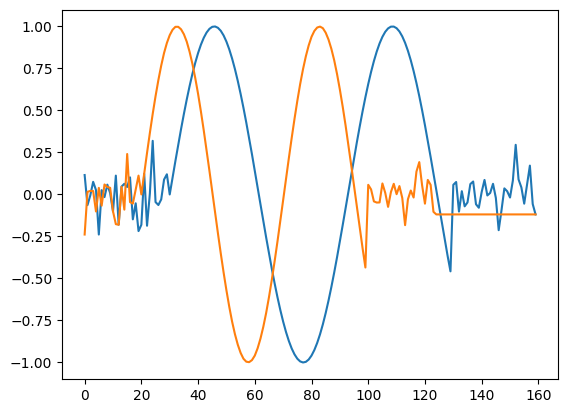

In [7]:
sample = np.concatenate([np.random.randn(30)/10,np.sin(np.arange(100)/10), np.random.randn(30)/10])

new_sample = align_tensor_by_se(sample.reshape(1,-1,1), [[30,130]], s_e_new=[20, 100], filling='fl')
plt.plot(sample)
plt.plot(new_sample[0,::,0])
plt.show()

### loading data

In [8]:
mt_file_clean = loadmat('data/ALIGNED_SER_4d_full.mat')

In [9]:
mt_file_clean.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data', 'starts', 'stops'])

In [10]:
labels_full = mt_file_clean['labels'][0]
labels_full

array([ 0,  1,  2, ..., 27, 42, 45])

In [11]:
data_full = mt_file_clean['data']
data_full.shape

(7420, 120, 67, 3)

In [12]:
data_4d = data_full[::,::,::,0:2]
data_4d.shape

(7420, 120, 67, 2)

In [13]:
# scaling
data_4d = shift_scale_sample_4d(data_4d, copy_data=True, do_flip=True)
data_4d.shape

(7420, 120, 67, 2)

In [14]:
starts, stops = mt_file_clean['starts'][0], mt_file_clean['stops'][0]
(starts, stops)

(array([20., 20., 20., ..., 20., 20., 20.]),
 array([76. , 63. , 76. , ..., 73. , 77.5, 59. ]))

### Dataset preparation

In [15]:
data_3d_full = data_4d.reshape(data_4d.shape[0], data_4d.shape[1], data_4d.shape[2]*data_4d.shape[3])
data_3d_full.shape

(7420, 120, 134)

In [16]:
se = np.stack([starts, stops], axis=1)
data_3d_full = align_tensor_by_se(data_3d_full, se, s_e_new=[30, 90])

(7420, 2)
0 procedures (from 7420) were skipped!


In [17]:
data_3d_train, data_3d_test, labels_train, labels_test = train_test_split(data_3d_full,
                                                                          labels_full,
                                                                          test_size=0.05)

data_3d_train.shape

(7049, 120, 134)

In [18]:
from torch.utils.data import Dataset, DataLoader

class Dataset_LSTM_Single(Dataset):
    def __init__(self, data, labels, window_size=30):

        self.data = data
        self.labels = labels
        self.uniq_labels = len(np.unique(self.labels))
        self.ws = window_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        gesture_seqence, label = self.data[idx], self.labels[idx]


        # slicing
        if self.ws < self.data.shape[1]: # window smaller than data length
            start_idx = np.random.randint(low=0, high=gesture_seqence.shape[0]-self.ws)
            gesture_seqence = gesture_seqence[start_idx: start_idx+self.ws]
            if start_idx < 20 or start_idx > 90 - 20:
                label = self.uniq_labels

        gesture_seqence = torch.tensor(gesture_seqence, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return gesture_seqence, label_tensor

In [19]:
DS_TRAIN = Dataset_LSTM_Single(data_3d_train, labels_train, window_size=30)
DL_TRAIN = DataLoader(DS_TRAIN, batch_size=64, shuffle=True)

DS_TEST_F = Dataset_LSTM_Single(data_3d_test, labels_test, window_size=120)
DL_TEST_F = DataLoader(DS_TEST_F, batch_size=64, shuffle=True)

DS_TEST_R = Dataset_LSTM_Single(data_3d_test, labels_test, window_size=30)
DL_TEST_R = DataLoader(DS_TEST_R, batch_size=64, shuffle=True)

DS_TEST_1 = Dataset_LSTM_Single(data_3d_test[::,0:30,::], [53]*len(labels_test), window_size=120)
DL_TEST_1 = DataLoader(DS_TEST_1, batch_size=64, shuffle=False)

DS_TEST_2 = Dataset_LSTM_Single(data_3d_test[::,30:60,::], labels_test, window_size=120)
DL_TEST_2 = DataLoader(DS_TEST_2, batch_size=64, shuffle=False)

DS_TEST_3 = Dataset_LSTM_Single(data_3d_test[::,60:90,::], labels_test, window_size=120)
DL_TEST_3 = DataLoader(DS_TEST_3, batch_size=64, shuffle=False)

DS_TEST_4 = Dataset_LSTM_Single(data_3d_test[::,90:120,::], [53]*len(labels_test), window_size=120)
DL_TEST_4 = DataLoader(DS_TEST_4, batch_size=64, shuffle=False)

for x, y in DL_TEST_F:
    print(x.shape, y.shape)
    break

torch.Size([64, 120, 134]) torch.Size([64])


In [20]:
device = 'cuda'

### LSTM

In [21]:
from misc.LSTM_simple_classifier import LSTMTagger

import torch

In [22]:
LSTM_model = LSTMTagger(N_input_features=134, hidden_dim=134, N_lstm_layers=1, dropout=0.1, # lstm
                 N_1d_filters=3, kernel_size=5, # 1d convolution
                 target_size=54, use_all_lstm_layers=True, # last linear layer
                 ).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=5e-4)

No batchnorm
dropout both


/home/a.shapirov/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
from torchmetrics import Accuracy, AUROC, F1Score, Precision, Recall, AveragePrecision
from collections import Counter
from sklearn.metrics import accuracy_score

accuracy = Accuracy(task="multiclass", num_classes=54).to(device)
f1_scorer = F1Score(task="multiclass", num_classes=54).to(device)
precision = Precision(task="multiclass", num_classes=54).to(device)
recall = Recall(task="multiclass", num_classes=54).to(device)

def validate(model, dl_test, metric):
    res = []
    with torch.no_grad():
        model.eval()
        for seq, tags in dl_test:
            seq, tags = seq.to(device), tags.to(device)
            pred_tags = model(seq)
            
            res.append(metric(torch.argmax(pred_tags, dim=1), tags).item())
    model.train(True)
    return np.mean(res)

In [24]:
acc_test_r, acc_test_1, acc_test_2, acc_test_3, acc_test_4 = [], [], [], [], []
prec_test_r, prec_test_1, prec_test_2, prec_test_3, prec_test_4 = [], [], [], [], []
rec_test_r, rec_test_1, rec_test_2, rec_test_3, rec_test_4 = [], [], [], [], []

precs = [prec_test_r, prec_test_1, prec_test_2, prec_test_3, prec_test_4]
recs = [rec_test_r, rec_test_1, rec_test_2, rec_test_3, rec_test_4]

dls = [DL_TEST_R, DL_TEST_1, DL_TEST_2, DL_TEST_3, DL_TEST_4]

losses = []

for epoch in tqdm(range(300)):

    if epoch % 5 == 0:
        for prec, rec, dl_test in zip(precs, recs, dls):
            prec.append(validate(LSTM_model, dl_test, precision))
            rec.append(validate(LSTM_model, dl_test, recall))

        acc_test_r.append(validate(LSTM_model, DL_TEST_R, accuracy))
        acc_test_1.append(validate(LSTM_model, DL_TEST_1, accuracy))
        acc_test_2.append(validate(LSTM_model, DL_TEST_2, accuracy))
        acc_test_3.append(validate(LSTM_model, DL_TEST_3, accuracy))
        acc_test_4.append(validate(LSTM_model, DL_TEST_4, accuracy))

    for seq, tags in DL_TRAIN:
        LSTM_model.zero_grad()
        seq, tags = seq.to(device), tags.to(device)
        
        # trimming
        trim_coef = torch.randint(low=2,high=4,size=(1,))
        seq = seq[::,::trim_coef,::]

        pred_tags = LSTM_model(seq)
        
#         print('tags', tags.shape)
#         print('pred_tags', pred_tags.shape)
        
        pred_tags = pred_tags.view(-1, pred_tags.shape[-1])

        # Cross entropy input size is (N, C) N-batchsize, C-num_classes
        # we can treat L(sequence length) as multiple of N
        tags = tags.view(-1)
        loss = loss_fn(pred_tags, tags)
        
        
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

100%|██████████| 300/300 [03:39<00:00,  1.36it/s]


In [173]:
torch.save(LSTM_model.state_dict(), 'LSTM_model_state_dict.pt')

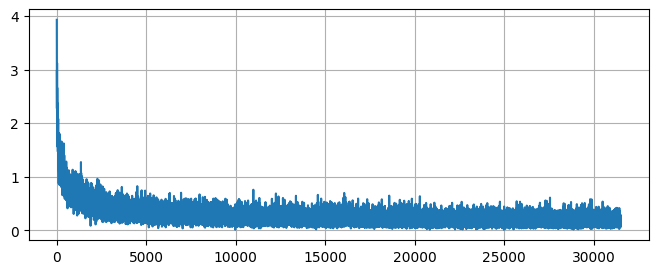

In [174]:
plt.figure(figsize=(8,3))
plt.plot(losses)
plt.grid(True)
plt.show()

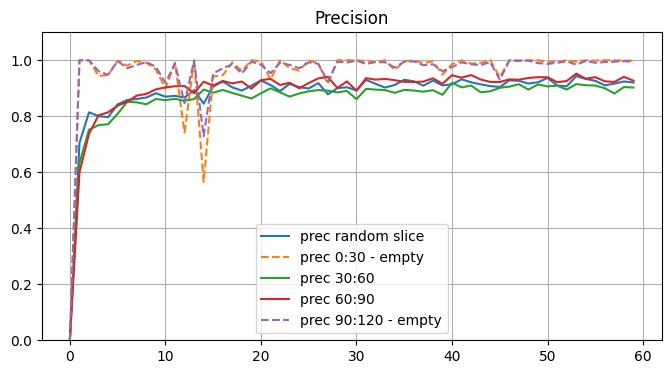

In [175]:
plt.figure(figsize=(8,4))
plt.title('Precision')
plt.plot(prec_test_r, label='prec random slice')
plt.plot(prec_test_1, '--', label='prec 0:30 - empty')
plt.plot(prec_test_2, label='prec 30:60')
plt.plot(prec_test_3, label='prec 60:90')
plt.plot(prec_test_4, '--', label='prec 90:120 - empty')

plt.ylim(0,1.1)
plt.grid(True)
plt.legend(loc='lower center')
plt.show()

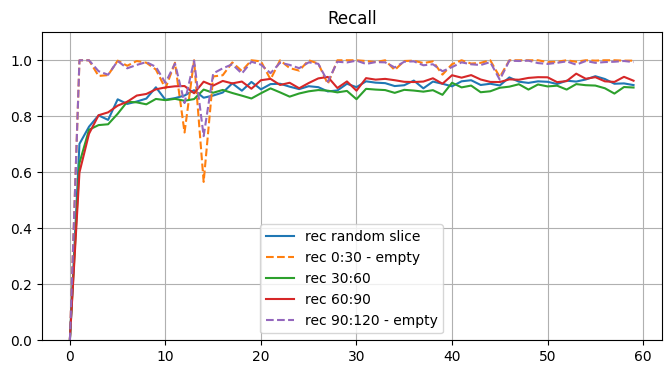

In [176]:
plt.figure(figsize=(8,4))
plt.title('Recall')
plt.plot(rec_test_r, label='rec random slice')
plt.plot(rec_test_1, '--', label='rec 0:30 - empty')
plt.plot(rec_test_2, label='rec 30:60')
plt.plot(rec_test_3, label='rec 60:90')
plt.plot(rec_test_4, '--', label='rec 90:120 - empty')

plt.ylim(0,1.1)
plt.grid(True)
plt.legend(loc='lower center')
plt.show()

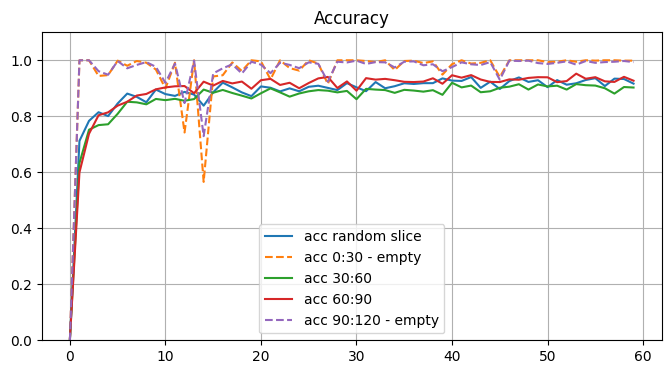

In [177]:
plt.figure(figsize=(8,4))
plt.title('Accuracy')
plt.plot(acc_test_r, label='acc random slice')
plt.plot(acc_test_1, '--', label='acc 0:30 - empty')
plt.plot(acc_test_2, label='acc 30:60')
plt.plot(acc_test_3, label='acc 60:90')
plt.plot(acc_test_4, '--', label='acc 90:120 - empty')

plt.ylim(0,1.1)
# plt.yticks([np.arange(11)/10])
plt.grid(True)
plt.legend(loc='lower center')
plt.show()

In [154]:
for x, y in DL_TEST_F:
    break

In [158]:
x_conct = torch.concat([x[i] for i in range(15)])
y_conct = np.concatenate([y[i].cpu().detach().numpy()*np.ones(120) for i in range(15)])


res = []
with torch.no_grad():
    LSTM_model.eval()
    for i in range(len(x_conct)-30):
        x_slice = x_conct[i:i+30:2]
        
        pred_tags = LSTM_model(torch.unsqueeze(x_slice,0).to(device))
        res.append(torch.argmax(pred_tags, dim=1).item())

    

In [159]:
x_conct.shape

torch.Size([1800, 134])

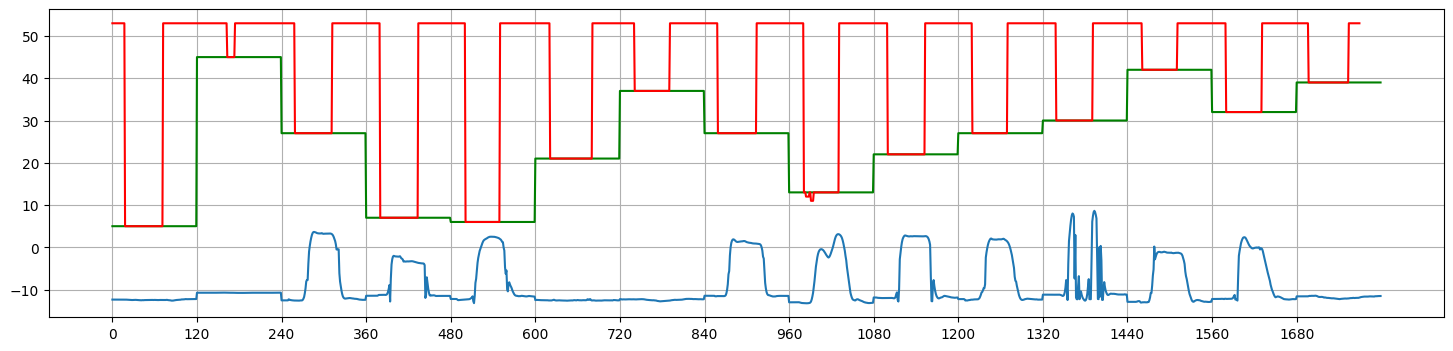

In [168]:
plt.figure(figsize=(18,4))
plt.plot(y_conct, 'g')
plt.plot(res, 'r')
plt.plot(x_conct[::,67+10].cpu().detach()*10)
plt.xticks([120*i for i in range(15)])
plt.grid(True)
plt.show()

### Classifiers

In [15]:
LDA = LinearDiscriminantAnalysis()
KNN = KNeighborsClassifier(n_neighbors=5)
RF = RandomForestClassifier(max_depth=10, n_estimators=50)
LR = LogisticRegression()

### 1. Right/wrong window classifier

In [16]:
window_data_true = []
window_data_false = []

window_size = 20
steps = np.arange(0,101,5)

for strt in tqdm(steps):
    data_3d_slice = data_3d_train[::,::,::]
    data_2d = data_3d_slice[::,strt:strt+window_size,::].reshape(data_3d_slice.shape[0],
                                                                 window_size*data_3d_slice.shape[2])
    if strt >= 20 and strt <= 30:
        window_data_true.append(data_2d)
    else:
        window_data_false.append(data_2d)
        
print(len(window_data_false))
print(len(window_data_true))

100%|███████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21076.90it/s]

18
3


In [17]:
def rnd_indx(coef=3/18):
    return np.random.choice(window_data_true[0].shape[0], size=int(window_data_true[0].shape[0]*coef))

In [18]:
window_data_array_true = np.concatenate(window_data_true)
window_data_array_false = np.concatenate([x[rnd_indx()] for x in window_data_false])
window_data_array = np.concatenate([window_data_array_true, window_data_array_false])
window_labels = [1]*window_data_array_true.shape[0] + [0]*window_data_array_false.shape[0]


window_data_array, window_labels = shuffle(window_data_array, window_labels, random_state=0)

print(window_data_array.shape)
print(len(window_labels))

(38607, 2680)
38607


In [22]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

In [23]:
# scaler = StandardScaler()
# data_2d_window = scaler.fit_transform(window_data_array.T).T

In [24]:
cv_scores = cross_val_score(estimator=pipe, X=window_data_array, y=window_labels)
print(cv_scores)

C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.88940689 0.88720539 0.88498899 0.89094677 0.88460044]


In [25]:
LR_window_clf = Pipeline([('scaler', StandardScaler()), ('LR', LR)])
LR_window_clf.fit(window_data_array, window_labels)

C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('LR', LogisticRegression())])

In [31]:
with open('LR_window_clf.pkl', 'wb') as f:
    pickle.dump(LR_window_clf, f)

### 2. Gesture classifier

In [27]:
gesture_labels = np.concatenate([labels_train for i in range(len(window_data_true))])
gesture_data = window_data_array_true

pipe = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

cv_scores = cross_val_score(estimator=pipe, X=gesture_data, y=gesture_labels)
print(cv_scores)

C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.88739322 0.92490937 0.96815122 0.96426722 0.94355256]


In [28]:
LR_gesture_clf = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])
LR_gesture_clf.fit(gesture_data, gesture_labels)

C:\Users\79219\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', StandardScaler()), ('LR', LogisticRegression())])

In [32]:
with open('LR_gesture_clf.pkl', 'wb') as f:
    pickle.dump(LR_gesture_clf, f)

### 3. Testing Window LDA + Gesture LDA

In [33]:
accuracy_list = []

window_size = 20
steps = np.arange(0,101,1)

for strt in tqdm(steps):
    data_3d_slice = data_3d_test[::,::,::]
    data_2d = data_3d_slice[::,strt:strt+window_size,::].reshape(data_3d_slice.shape[0],
                                                                 window_size*data_3d_slice.shape[2])
    
    pred_labels = np.ones_like(labels_test)*-1
    pred_window_mask = LR_window_clf.predict(data_2d)
    if np.sum(pred_window_mask) > 0:
        data_2d_masked = data_2d[pred_window_mask==1]
        pred_labels_masked = LR_gesture_clf.predict(data_2d_masked)
        pred_labels[pred_window_mask==1] = pred_labels_masked
    
    acc = accuracy_score(labels_test, pred_labels)
    accuracy_list.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:02<00:00, 46.04it/s]


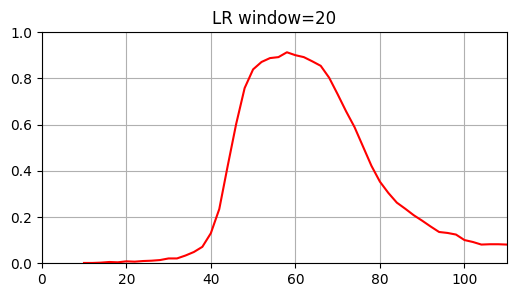

In [35]:
plt.figure(figsize=(6,3))
plt.title(f'LR window={window_size}')
plt.plot(steps*2 + window_size//2, accuracy_list, 'r')

plt.grid(True)
plt.ylim(0,1)
plt.xlim(0,110)
plt.show()

### Shifting window accuracy check

In [ ]:
# from sklearn.utils import shuffle
# labels = shuffle(labels, random_state=0)

In [ ]:
lda_scores_mean = []
lda_scores_std = []
steps = np.arange(0,41,5)
window_size = 20
for strt in tqdm(steps):
    data_3d_slice = data_3d[::,::2,::]
    data_2d = data_3d_slice[::,strt:strt+window_size,::].reshape(data_3d_slice.shape[0],window_size*data_3d_slice.shape[2])
    
    scaler = StandardScaler()
    data_2d = scaler.fit_transform(data_2d.T).T
    
    cv_scores = cross_val_score(estimator=LDA, X=data_2d, y=labels)
    lda_scores_mean.append(np.mean(cv_scores))
    lda_scores_std.append(np.std(cv_scores))    

In [ ]:
data_3d_slice.shape

In [ ]:
1/len(np.unique(labels))

In [ ]:
plt.figure(figsize=(6,3))
plt.title(f'LDA window={window_size}')
plt.plot(steps*2 + window_size//2, np.array(lda_scores_mean) + 3*np.array(lda_scores_std), 'g', alpha=0.3)
plt.plot(steps*2 + window_size//2, lda_scores_mean, 'r')
plt.plot(steps*2 + window_size//2, np.array(lda_scores_mean) - 3*np.array(lda_scores_std), 'g', alpha=0.3)

plt.grid(True)
plt.ylim(0,1)
plt.xlim(0,110)
plt.show()

### Consequitive model

In [ ]:
window_size = 20

data_3d_resh = np.concatenate([data_3d[::,20:40,::],
                               ])

print(data_3d_resh.shape)

data_2d_resh = data_3d_resh.reshape(data_3d_resh.shape[0],
                                    data_3d_resh.shape[1]*data_3d_resh.shape[2])
print(data_2d_resh.shape)

In [ ]:
scaler = StandardScaler()
data_2d_resh = scaler.fit_transform(data_2d_resh.T).T

In [ ]:
cv_scores = cross_val_score(estimator=LDA,
                            X=data_2d_resh,
                            y=np.concatenate([labels]*1),
                            )
print(cv_scores)

### Sequential prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(data_3d, labels, test_size=0.2, random_state=42)
print(X_train.shape)

In [ ]:
window_size = 20

X1 = X_train[::,0:window_size,::].reshape(X_train.shape[0],window_size*X_train.shape[2])
X2 = X_train[::,20:20+window_size,::].reshape(X_train.shape[0],window_size*X_train.shape[2])
X3 = X_train[::,40:40+window_size,::].reshape(X_train.shape[0],window_size*X_train.shape[2])
X4 = X_train[::,60:60+window_size,::].reshape(X_train.shape[0],window_size*X_train.shape[2])
X5 = X_train[::,80:80+window_size,::].reshape(X_train.shape[0],window_size*X_train.shape[2])

print(X_train1.shape)

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda_model
from sklearn.ensemble import RandomForestClassifier as lda_model
LDA1, LDA2, LDA3, LDA4, LDA5 = lda_model(), lda_model(), lda_model(), lda_model(), lda_model()
LDA1.fit(X1, y_train)
LDA2.fit(X2, y_train)
LDA3.fit(X3, y_train)
LDA4.fit(X4, y_train)
LDA5.fit(X5, y_train)

In [ ]:
p1, p2, p3, p4, p5 = [], [], [], [], []
for X_slice in [X1, X2, X3, X4, X5]:
    for model, p_list in zip([LDA1,LDA2,LDA3,LDA4,LDA5], [p1,p2,p3,p4,p5]):
        p_list.append(model.predict_proba(X_slice))

In [ ]:
print(accuracy_score(y_train, np.argmax((p1[0] + p2[0] + p3[0] + p4[0] + p5[0])/5,  axis=1)))
print(accuracy_score(y_train, np.argmax((p1[1] + p2[1] + p3[1] + p4[1] + p5[1])/5,  axis=1)))
print(accuracy_score(y_train, np.argmax((p1[2] + p2[2] + p3[2] + p4[2] + p5[2])/5,  axis=1)))
print(accuracy_score(y_train, np.argmax((p1[3] + p2[3] + p3[3] + p4[3] + p5[3])/5,  axis=1)))
print(accuracy_score(y_train, np.argmax((p1[4] + p2[4] + p3[4] + p4[4] + p5[4])/5,  axis=1)))

In [ ]:
aaa = (p1[0] + p2[0] + p3[0] + p4[0] + p5[0])/5
bbb = (p1[4] + p2[4] + p3[4] + p4[4] + p5[4])/5

plt.figure(figsize=(6,2))
plt.plot(aaa[50], 'r')
plt.plot(bbb[50], 'g')
plt.show()

In [ ]:
cnt = 0
for i in range(aaa.shape[0]):
    if np.max(aaa[i]) > np.max(bbb[i]):
        cnt += 1
print(cnt)

In [ ]:
print(accuracy_score(y_train, np.argmax(np.array(p5)[4], axis=1)))
print(accuracy_score(y_train, np.argmax(np.mean(np.array(p5),axis=0), axis=1)))

In [ ]:
p1m, p2m, p3m, p4m, p5m = np.mean(p1,axis=0),np.mean(p2,axis=0),np.mean(p3,axis=0),np.mean(p4,axis=0), np.mean(p5,axis=0)
ppm = (p1m + p2m + p3m + p4m + p5m)/5
print(accuracy_score(y_train, np.argmax(ppm,  axis=1)))

In [ ]:
final_features = np.concatenate(p1+p2+p3+p4+p5, axis=1)
print(final_features.shape)

LDA_final = lda_model()
LDA_final.fit(final_features, y_train)

### prediction

In [ ]:
window_size = 20

X1t = X_test[::,0:window_size,::].reshape(X_test.shape[0],window_size*X_train.shape[2])
X2t = X_test[::,20:20+window_size,::].reshape(X_test.shape[0],window_size*X_train.shape[2])
X3t = X_test[::,20:20+window_size,::].reshape(X_test.shape[0],window_size*X_train.shape[2])
X4t = X_test[::,20:20+window_size,::].reshape(X_test.shape[0],window_size*X_train.shape[2])
X5t = X_test[::,20:20+window_size,::].reshape(X_test.shape[0],window_size*X_train.shape[2])

print(X1t.shape)

p1t, p2t, p3t, p4t, p5t = [], [], [], [], []
for X_slice in [X1t, X2t, X3t, X4t, X5t]:
    for model, p_list in zip([LDA1,LDA2,LDA3,LDA4,LDA5], [p1t,p2t,p3t,p4t,p5t]):
        p_list.append(model.predict_proba(X_slice))
        

In [ ]:
p1mt, p2mt, p3mt, p4mt, p5mt = np.mean(p1t,axis=0),np.mean(p2t,axis=0),np.mean(p3t,axis=0),np.mean(p4t,axis=0), np.mean(p5t,axis=0)
ppmt = (p1mt + p2mt + p3mt + p4mt + p5mt)/5
print(accuracy_score(y_test, np.argmax((p1t[0] + p2t[0] + p3t[0] + p4t[0] + p5t[0])/5,  axis=1)))
print(accuracy_score(y_test, np.argmax((p1t[1] + p2t[1] + p3t[1] + p4t[1] + p5t[1])/5,  axis=1)))
print(accuracy_score(y_test, np.argmax((p1t[2] + p2t[2] + p3t[2] + p4t[2] + p5t[2])/5,  axis=1)))
print(accuracy_score(y_test, np.argmax((p1t[3] + p2t[3] + p3t[3] + p4t[3] + p5t[3])/5,  axis=1)))
print(accuracy_score(y_test, np.argmax((p1t[4] + p2t[4] + p3t[4] + p4t[4] + p5t[4])/5,  axis=1)))

In [ ]:
p1, p2, p3, p4, p5 = [], [], [], [], []
for X_slice in [X1, X2, X3, X4, X5]:
    for model, p_list in zip([LDA1,LDA2,LDA3,LDA4,LDA5], [p1,p2,p3,p4,p5]):
        p_list.append(model.predict_log_proba(X_slice))

In [ ]:
NNN = 11
print(y_test[NNN])
print(np.argmax(LDA.predict_proba(X_test[NNN].reshape(1, -1))))

plt.figure(figsize=(6,2))
plt.plot(LDA.predict_proba(X_test[NNN].reshape(1, -1))[0])
plt.yscale('log')
plt.ylim(1e-32, 10)
plt.show()

In [ ]:
def generate_resp(x):
    p1 = LDA.predict_proba(x.reshape(1, -1))
    p2 = LDA.predict_proba(x.reshape(1, -1))    
    p3 = LDA.predict_proba(x.reshape(1, -1))    
    p4 = LDA.predict_proba(x.reshape(1, -1))    
    p5 = LDA.predict_proba(x.reshape(1, -1))    
    p_res = np.concatenate([p1,p2,p3,p4,p5])
#     print(p_res.shape)
    return np.mean(p_res,axis=0)

In [ ]:
%timeit generate_resp(data_2d_resh[10].reshape(-1,1))